In [5]:
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from openaq import OpenAQ

In [6]:
# Parameters
RADIUS = 10_000
LIMIT = 3
DATE_RANGE = [datetime.now() - timedelta(days=1), datetime.now()]

In [7]:
# Put your OpenAQ API key in a text file with the name "openaq_api_key.txt"
with open("api_keys/openaq_api_key.txt", "r") as file:
    API_KEY = file.read()

# Initialize the OpenAQ client
client = OpenAQ(api_key=API_KEY)

In [8]:
# Function to fetch sensor data near a given location, return a dataframe where each row is a sensor and has data about the location and one column contains the measurements
def fetch_nearby_sensors(latitude, longitude, radius=10_000, limit=3):
    # Get the locations near the given coordinates
    response = client.locations.list(coordinates=(latitude, longitude), radius=radius, limit=limit)

    format_string = "%Y-%m-%dT%H:%M:%SZ"
    data = {}
    m_id = 0
    # For each location in the response, fetch its sensors
    for location in response.results:
        for sensor in location.sensors:
            lat = location.coordinates.latitude
            long = location.coordinates.longitude
            loc_name = location.name
            location_id = location.id
            sensor = sensor.id

            # Fetch the recent measurements the sensor
            measurements = client.measurements.list(sensor)

            # For each measurement, record the relevant data
            for measurement in measurements.results:
                m_id += 1
                epoch = datetime.strptime(measurement.period.datetime_from.utc, format_string)
                duration = timedelta(seconds=pd.to_timedelta(measurement.period.interval).seconds)
                parameter = measurement.parameter.name
                value = measurement.value
                units = measurement.parameter.units

                data[m_id] = {
                    "measurement_id": m_id,
                    "sensor_id": sensor,
                    "location_id": location_id,
                    "location": loc_name,
                    "latitude": lat,
                    "longitude": long,
                    "epoch": epoch,
                    "duration": duration,
                    "parameter": parameter,
                    "value": value,
                    "units": units,
                }

    return pd.DataFrame.from_dict(data, orient="index")

In [10]:
# Example: Get sensors within 10km of Los Angeles (34.0549, -118.2426)
df = fetch_nearby_sensors(latitude=34.0549, longitude=-118.2426, radius=RADIUS, limit=LIMIT)

In [11]:
# Display results
df.head()

,measurement_id,sensor_id,location_id,location,latitude,longitude,epoch,duration,parameter,value,units
1,1,8681,1575,Los Angeles - N. Mai,34.0669,-118.2417,2016-11-15 20:00:00,0 days 01:00:00,co,0.71,ppm
2,2,8681,1575,Los Angeles - N. Mai,34.0669,-118.2417,2016-11-16 00:00:00,0 days 01:00:00,co,0.55,ppm
3,3,8681,1575,Los Angeles - N. Mai,34.0669,-118.2417,2016-11-16 01:00:00,0 days 01:00:00,co,0.57,ppm
4,4,8681,1575,Los Angeles - N. Mai,34.0669,-118.2417,2016-11-16 02:00:00,0 days 01:00:00,co,0.54,ppm
5,5,8681,1575,Los Angeles - N. Mai,34.0669,-118.2417,2016-11-16 03:00:00,0 days 01:00:00,co,0.43,ppm


In [12]:
# Basic Info
print("Basic Info:")
print(df.info())

Basic Info:
<class 'pandas.core.frame.DataFrame'>
Index: 17000 entries, 1 to 17000
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype          
---  ------          --------------  -----          
 0   measurement_id  17000 non-null  int64          
 1   sensor_id       17000 non-null  int64          
 2   location_id     17000 non-null  int64          
 3   location        17000 non-null  object         
 4   latitude        17000 non-null  float64        
 5   longitude       17000 non-null  float64        
 6   epoch           17000 non-null  datetime64[ns] 
 7   duration        17000 non-null  timedelta64[ns]
 8   parameter       17000 non-null  object         
 9   value           17000 non-null  float64        
 10  units           17000 non-null  object         
dtypes: datetime64[ns](1), float64(3), int64(3), object(3), timedelta64[ns](1)
memory usage: 1.6+ MB
None


In [13]:
# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())


Missing Values:
measurement_id    0
sensor_id         0
location_id       0
location          0
latitude          0
longitude         0
epoch             0
duration          0
parameter         0
value             0
units             0
dtype: int64


In [14]:
# Summary Statistics
print("\nSummary Statistics:")
print(df.describe())


Summary Statistics:
       measurement_id     sensor_id    location_id      latitude  \
count    17000.000000  1.700000e+04   17000.000000  17000.000000   
mean      8500.500000  8.053175e+05   55552.705882     34.065774   
min          1.000000  2.772000e+03    1575.000000     34.061776   
25%       4250.750000  8.683000e+03    1575.000000     34.066429   
50%       8500.500000  2.519300e+04    7936.000000     34.066429   
75%      12750.250000  1.654126e+06    7936.000000     34.066900   
max      17000.000000  4.272361e+06  290486.000000     34.066900   
std       4907.621624  1.407850e+06  108793.694657      0.001863   

          longitude                          epoch                   duration  \
count  17000.000000                          17000                      17000   
mean    -118.236991  2018-11-10 08:06:10.721999872  0 days 00:49:56.470588235   
min     -118.254870            2016-10-10 07:00:00            0 days 00:03:00   
25%     -118.241700            2017-04-18 

In [19]:
# Show unique location ids in dataset

locations = df['location_id'].unique()
print("\nUnique Location IDs: ", locations)
print("Number of location ids:", len(locations))


Unique Location IDs:  [  1575   7936 290486]
Number of location ids: 3


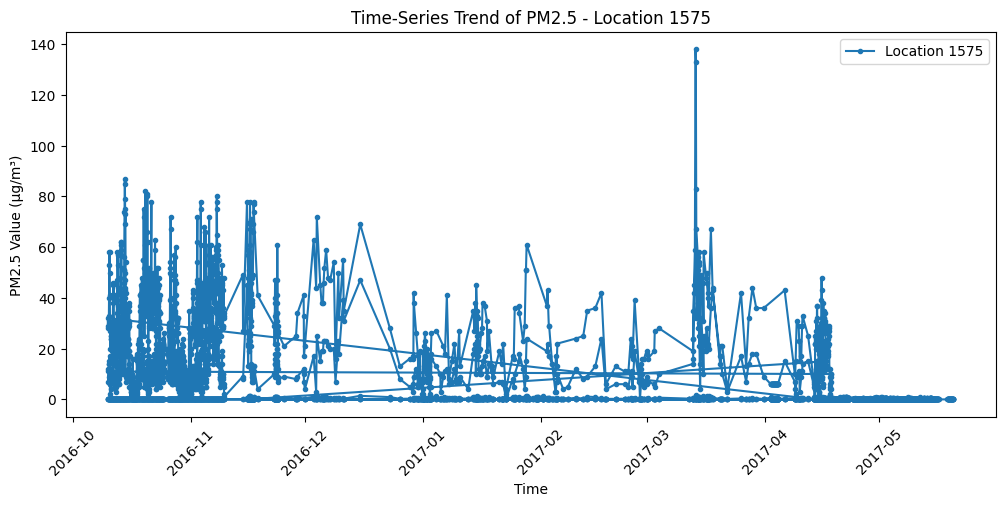

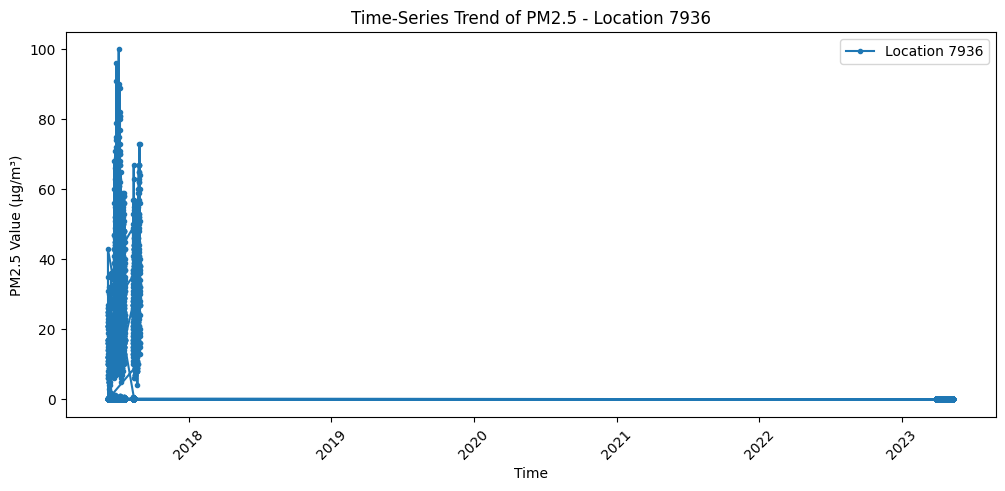

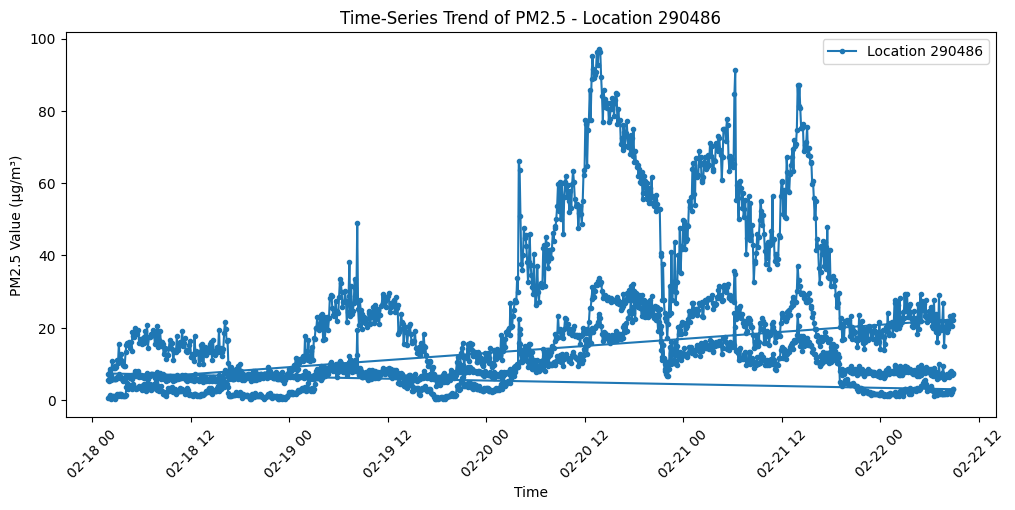

In [20]:
# Loop through each unique location_id
for location in locations:
    df_location = df[df['location_id'] == location]  # Filter data for this location
    
    plt.figure(figsize=(12, 5))
    plt.plot(df_location['epoch'], df_location['value'], marker='o', linestyle='-', markersize=3, label=f"Location {location}")
    plt.xlabel("Time")
    plt.ylabel("PM2.5 Value (µg/m³)")
    plt.title(f"Time-Series Trend of PM2.5 - Location {location}")
    plt.xticks(rotation=45)
    plt.legend()
    plt.show()
